In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..") ## resetting the path to the parent directory

In [2]:
from src.pipeline import *

In [3]:
from src.url_csv import df_join
from src.plots import roc_auc_plot

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, auc, plot_roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV
import eli5
import warnings

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import random

random.seed(42)

## Data Preparation

In [7]:
df1 = pd.read_csv('../data/ht_match.csv')
df2 = pd.read_csv('../data/ht_match_ind.csv')

df1_test = pd.read_csv('../data/ht_match_na.csv')
df2_test = pd.read_csv('../data/ht_match_ind_na.csv')

df = df_join(df1,df2)
df_test = df_join(df1_test, df2_test)

In [8]:
y = df['win']
X = df.drop(columns=['match_id','win'])

X_cols = X.columns

In [9]:
len(y)

19868

In [10]:
len(X)

19868

#### Converting team names ('red', 'blue') to 1 and 0

In [11]:
mask = {'blue':0,'red':1}
X['teams'] = X['teams'].replace(mask)
df_test['teams'] = df_test['teams'].replace(mask)

In [12]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3)

## Pipeline

In [13]:
num_features, cat_features = feature_separator(X)

In [14]:
scaled_pl = pipeline(True,num_features,False, True)
unscaled_pl = pipeline(True,num_features,False, False)

In [15]:
lrc_s = append_model(LogisticRegression(), scaled_pl)
lrc_u = append_model(LogisticRegression(), unscaled_pl)

rfc_s = append_model(RandomForestClassifier(n_jobs = -1), scaled_pl)
rfc_u = append_model(RandomForestClassifier(n_jobs = -1), unscaled_pl)

gbc_s = append_model(GradientBoostingClassifier(), scaled_pl)
gbc_u = append_model(GradientBoostingClassifier(), unscaled_pl)

abc_s = append_model(AdaBoostClassifier(), scaled_pl)
abc_u = append_model(AdaBoostClassifier(), unscaled_pl)

nbc_s = append_model(GaussianNB(), scaled_pl)
nbc_u = append_model(GaussianNB(), unscaled_pl)

## Establishing an initial base model without any feature engineering 

In [16]:
clfs = {'scaled log reg': lrc_s,
        'unscaled random forest': rfc_u,
        'scaled gradient boost': gbc_s,
        'scaled gradient boost': abc_s,
        'scaled Bayesian': nbc_s}

model_scorer(clfs,X_train,y_train,X_validation,y_validation)

Mean cross validatin score for scaled log reg: 0.89
Precision score for scaled log reg: 0.91
Recall score for scaled log reg: 0.87


Mean cross validatin score for unscaled random forest: 0.90
Precision score for unscaled random forest: 0.90
Recall score for unscaled random forest: 0.89


Mean cross validatin score for scaled gradient boost: 0.89
Precision score for scaled gradient boost: 0.90
Recall score for scaled gradient boost: 0.88


Mean cross validatin score for scaled Bayesian: 0.84
Precision score for scaled Bayesian: 0.85
Recall score for scaled Bayesian: 0.84




## Comparing ROC AUC Curves for base models

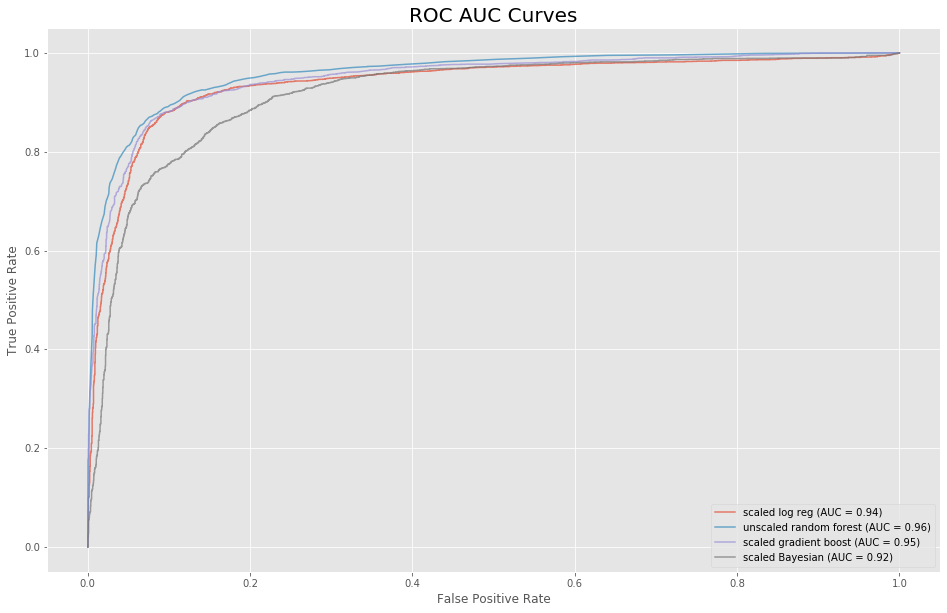

In [17]:
fig,ax = plt.subplots(figsize=(16,10))

roc_auc_plot(ax, clfs, X_train, y_train, X_validation, y_validation)

## Feature engineering with a chosen model

##### Logistic regression coefficients

In [18]:
weight_explainer(lrc_s,num_features)

Weight?,Feature
+3.970,xp
+1.824,firstInhibitor
+0.870,firstBaron
+0.657,firstTower
+0.556,totalKills
+0.390,firstDragon
+0.341,<BIAS>
+0.168,firstBlood
+0.083,firstRiftHerald
+0.013,teams


In [19]:
lrc_s.named_steps['estimator'].coef_

array([[ 0.01319336,  0.16779716,  0.65719603,  1.82378399,  0.87045087,
         0.39000432,  0.08269685, -2.35827172, -2.50088654,  3.9703558 ,
         0.55602025, -0.46628766, -0.03049812]])

##### Random forest feature importance

In [20]:
weight_explainer(rfc_u,num_features)

Weight,Feature
0.3199 ± 0.1995,firstInhibitor
0.1185 ± 0.1366,firstTower
0.0893 ± 0.0571,totalDeaths
0.0766 ± 0.0396,totalGold
0.0755 ± 0.0989,firstBaron
0.0739 ± 0.0343,xp
0.0737 ± 0.0427,level
0.0552 ± 0.0398,totalKills
0.0444 ± 0.0248,level_ups
0.0311 ± 0.0541,firstDragon


Which features to use before hyperparameter tuning?

## Tuning hyperparameters

In [21]:
params = {'estimator__n_estimators': (10, 100,1000,10000),
         'estimator__max_depth': (2,4,6,None),
         'estimator__max_features': (3,6,'auto'),
         }

search = GridSearchCV(rfc_u,params,n_jobs=-1,verbose=1)
search.fit(X,y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 18.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numeric',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('num_imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                   

## CV score against the entire training dataset

## Confusion Matrix

## Using the best model against the test dataset

## Result